# Exercício 3 - NLP

### Questão 1

Objetivo: prever se uma mensagem é spam ou não.

a) Qual porcentagem dos documentos são spam?

b) Usando mala de palavras (CountVectorizer), qual é o token mais longo do vocabulário dos dados de treinamento? Utilize o modelo de classificação multinomial Naive Bayes e encontre a (AUC) usando os dados de teste.

c) Utilize o vetorizador Tf-idf nos dados de treinamento. Quais 20 características têm o menor tf-idf e quais 20 têm o maior tf-idf? Coloque essas características em duas séries, onde cada série é classificada pelo valor tf-idf e, em seguida, em ordem alfabética pelo nome da característica. O índice da série deve ser o nome da característica e os dados devem ser o tf-idf. A série de 20 características com o menor tf-idfs deve ser classificada de forma crescente, a lista de 20 características com o maior tf-idfs deve ser classificada de forma decrescente.

d) Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 3. Use o modelo classificador multinomial Naive Bayes com alfa = 0.1, e então calcule a pontuação AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro alfa e descreva brevemente como esse parâmetro se comporta no modelo.

e) Qual é o tamanho médio dos documentos (número de caracteres) para documentos não-spam e documentos spam? Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 5. Usando essa matriz de termos de documento e um característica  adicional (o comprimento do documento (número de caracteres)), treine um modelo SVC, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo.

f) Qual é o número médio de dígitos por documento para documentos não-spam e documentos spam? Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 5 e utilize unigramas, bigramas e trigramas. Usando essa matriz de termos de documento e duas características  adicionais (o comprimento do documento e o número médio de dígitos por documento) treine um modelo de regressão logística, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo.

g) Qual é o número médio de caracteres que não são palavras (tudo que não é uma letra, dígito ou underscore) por documento para documentos não-spam e documentos spam? Dica: use as classes de caracteres \w e \W do pacote re (regular expressions). Utilize o vetorizador CountVectorizer nos dados de treinamento, ignorando termos menor que 5 e utilize unigramas, bigramas e trigramas. Usando esta matriz de termos de documento e as seguintes características adicionais: o comprimento do documento, número de dígitos por documento, e o número de caracteres que não são palavras (tudo que não é uma letra, dígito ou underscore), treine um modelo de regressão logística, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo. Encontre os 10 menores e os 10 maiores coeficientes do modelo e retorne-os juntamente com a pontuação da AUC em uma tupla. A lista dos 10 menores coeficientes deve ser classificada de forma crescente, a lista dos 10 maiores coeficientes de forma decrescente.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [15]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import sklearn.metrics as metrics

In [3]:
# constants
DATA_DIR = 'CSV'
SPAM_FILE = 'spam.csv'

NOT_WORDS = 'not_words'
DIGITS = 'digits'
DOC_SIZE = 'doc_size'

In [4]:
spam_data = pd.read_csv(os.path.join(DATA_DIR, SPAM_FILE))

spam_data['target'] = np.where(spam_data['target']=='spam',1,0)
spam_data.head(10)

,text,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0
5,FreeMsg Hey there darling it's been 3 week's n...,1
6,Even my brother is not like to speak with me. ...,0
7,As per your request 'Melle Melle (Oru Minnamin...,0
8,WINNER!! As a valued network customer you have...,1
9,Had your mobile 11 months or more? U R entitle...,1


# Preparação dos dados

### Tendo em vista os pedidos subsequentes, realizarei uma preparação do dataframe para ser capaz de responder a todos os ítens mais facilmente.

In [35]:
# Retorna os caracteres que não compõem palavras
def non_word_chars(chunk):
    return re.findall('\W', chunk)

# retorna o número de dígitos em uma string (usaremos sobre documentos documents)
def count_digits(chunk):
    return len(re.findall('\d', chunk))

# Retorna estatísticas sobre uma característica
def feature_stats(df, feature, spam=1):
    return spam_data[spam_data.target == spam].loc[:,[feature]].describe().T

# Exibe a curva ROC com o valor de AUC
def plot_roc_auc(y_test, probs):
    fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
    roc_auc = metrics.roc_auc_score(y_test, probs)

    plt.figure(figsize=(12,6))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return roc_auc

In [6]:
# tamanho de cada documento
spam_data[DOC_SIZE] = spam_data.text.apply(lambda x: len(x))
# número de caracteres que não compõem palavras
spam_data[NOT_WORDS] = spam_data.text.apply(lambda x: len(non_word_chars(x)))
# número de dígitos no documento
spam_data[DIGITS] = spam_data.text.apply(count_digits)

In [7]:
spam_data.head(10)

,text,target,doc_size,not_words,digits
0,"Go until jurong point, crazy.. Available only ...",0,111,28,0
1,Ok lar... Joking wif u oni...,0,29,11,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,33,25
3,U dun say so early hor... U c already then say...,0,49,16,0
4,"Nah I don't think he goes to usf, he lives aro...",0,61,14,0
5,FreeMsg Hey there darling it's been 3 week's n...,1,148,40,4
6,Even my brother is not like to speak with me. ...,0,77,17,0
7,As per your request 'Melle Melle (Oru Minnamin...,0,160,31,1
8,WINNER!! As a valued network customer you have...,1,158,32,19
9,Had your mobile 11 months or more? U R entitle...,1,154,30,13


## a) Qual porcentagem dos documentos são spam?

In [8]:
spam_data.target.unique()

array([0, 1])

Os únicos valores presentes na série "target" são 0 e 1. Os documentos classificados como spam possuem valor 1 nesta série. Assim sendo, podemos obter o percentual de spam da base com uma simples soma e divisão

In [9]:
spam_ratio = spam_data.target.sum()/spam_data.target.size
print('=> O percentual de documentos que são spam é {0:.2f}%'.format(spam_ratio*100))

=> O percentual de documentos que são spam é 13.41%


## Usando mala de palavras (CountVectorizer), qual é o token mais longo do vocabulário dos dados de treinamento?

In [10]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(spam_data['text'], 
                                                    spam_data['target'], 
                                                    random_state=0)

In [12]:
cv = CountVectorizer()
bow_train = cv.fit_transform(X_train)
bow_train.shape

(4179, 7354)

In [13]:
tokens = cv.get_feature_names()
tokens.sort(key=len, reverse=True)
print("=> O token mais longo do vocabulário dos dados de treinamento é: {} ({} caracteres)".format(
    tokens[0], len(tokens[0])))
print("Para referência, o segundo maior é: {}".format(tokens[1]))

=> O token mais longo do vocabulário dos dados de treinamento é: com1win150ppmx3age16subscription (32 caracteres)
Para referência, o segundo maior é: minmoremobsemspobox45po139wa


## Utilize o modelo de classificação multinomial Naive Bayes e encontre a (AUC) usando os dados de teste.

In [17]:
mnb_model = MultinomialNB()
mnb_model.fit(bow_train, y_train)

bow_test = cv.transform(X_test)
probs = mnb_model.predict_proba(bow_test)[:, 1]

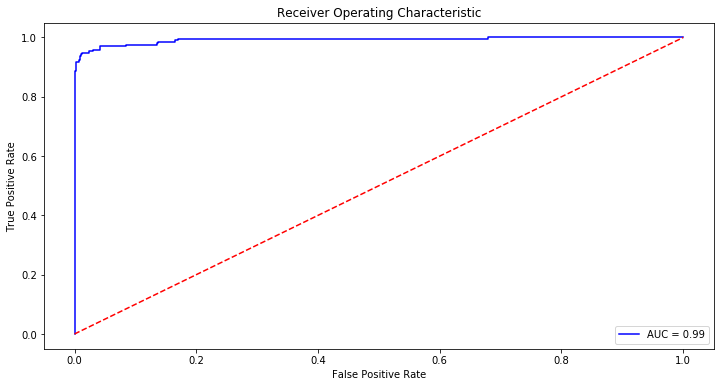

AUC: 0.9919783372663531


In [36]:
auc = plot_roc_auc(y_test, probs)
print("AUC: {}".format(auc))

## c) Utilize o vetorizador Tf-idf nos dados de treinamento. 

In [26]:
tfidf_vectorizer = TfidfVectorizer()
train_matrix = tfidf_vectorizer.fit_transform(X_train)
train_matrix.shape

(4179, 7354)

## Quais 20 características têm o menor tf-idf e quais 20 têm o maior tf-idf? Coloque essas características em duas séries, onde cada série é classificada pelo valor tf-idf e, em seguida, em ordem alfabética pelo nome da característica. O índice da série deve ser o nome da característica e os dados devem ser o tf-idf. A série de 20 características com o menor tf-idfs deve ser classificada de forma crescente, a lista de 20 características com o maior tf-idfs deve ser classificada de forma decrescente.

In [54]:
features = np.array(tfidf_vectorizer.get_feature_names())

tfidf_sorted = np.sort(train_matrix.toarray()).flatten()
sorting_indices = np.argsort(train_matrix.toarray()).flatten()

In [55]:
limit = 20
df_lowest = pd.Series(tfidf_sorted[:limit], index=features[sorting_indices][:limit])[::-1]
df_highest = pd.Series(tfidf_sorted[-limit:], index=features[sorting_indices][-limit:])[::-1]

In [56]:
df_lowest

petey              0.0
petrol             0.0
petticoatdreams    0.0
pg                 0.0
ph                 0.0
pharmacy           0.0
phd                0.0
photo              0.0
phews              0.0
phil               0.0
philosophical      0.0
philosophy         0.0
phne               0.0
phoenix            0.0
phone              0.0
phonebook          0.0
phoned             0.0
phones             0.0
phony              0.0
00                 0.0
dtype: float64

In [57]:
df_highest

wont           0.565857
dare           0.347443
stupid         0.311998
you            0.305559
hear           0.275090
talk           0.258698
anything       0.241310
after          0.225107
tell           0.213221
to             0.197660
how            0.179845
ended          0.000000
emergency      0.000000
else           0.000000
elsewhere      0.000000
em             0.000000
email          0.000000
enemy          0.000000
embarassed     0.000000
embarassing    0.000000
dtype: float64

## d) Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 3. 

In [21]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w\w\w+\b")
train_matrix = tfidf_vectorizer.fit_transform(X_train)

## Use o modelo classificador multinomial Naive Bayes com alfa = 0.1, e então calcule a pontuação AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro alfa e descreva brevemente como esse parâmetro se comporta no modelo.

In [58]:
test_matrix = tfidf_vectorizer.transform(X_test)
mnb_model = MultinomialNB(alpha=0.1)
mnb_model.fit(train_matrix, y_train)
probs = mnb_model.predict_proba(test_matrix)[:, 1]

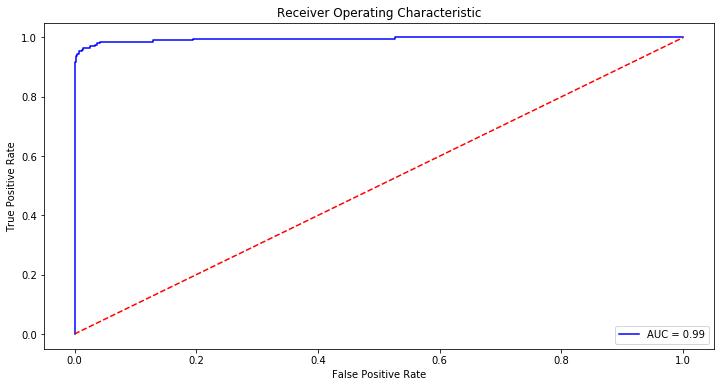

0.9947074003021917

In [59]:
plot_roc_auc(y_test, probs)

## e) Qual é o tamanho médio dos documentos (número de caracteres) para documentos não-spam e documentos spam? 

In [60]:
df = feature_stats(spam_data, DOC_SIZE, spam=1)
print('=> Média do tamanho dos documentos que são SPAM: {:.2f}'.format(df.loc[DOC_SIZE,'mean']))
df

=> Média do tamanho dos documentos que são SPAM: 138.87


,count,mean,std,min,25%,50%,75%,max
doc_size,747.0,138.866131,29.183082,13.0,132.5,149.0,157.0,224.0


In [61]:
df = feature_stats(spam_data, DOC_SIZE, spam=0)
print('=> Média do tamanho dos documentos que NÃO são SPAM: {:.2f}'.format(df.loc[DOC_SIZE,'mean']))
df

=> Média do tamanho dos documentos que NÃO são SPAM: 71.02


,count,mean,std,min,25%,50%,75%,max
doc_size,4825.0,71.023627,58.016023,2.0,33.0,52.0,92.0,910.0


## Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 5. Usando essa matriz de termos de documento e um característica adicional (o comprimento do documento (número de caracteres)), treine um modelo SVC, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo.

In [53]:
from scipy.sparse import hstack

In [ ]:
docsize_train, docsize_test, digits_train, digits_test = train_test_split(
                                                    spam_data.doc_size, 
                                                    spam_data.digits, 
                                                    random_state=0)

In [54]:
train_docsize, test_docsize = train_test_split(spam_data.doc_size, random_state=0)

In [56]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix =  tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)
print(tfidf_matrix.shape, tfidf_test.shape)

(4179, 7354) (1393, 7354)


In [63]:
# Vamos adicionar os valores de número de dígitos e número de caracteres que não são palavras à matriz 
# de ocorrência dos tokens (mala de palavras) para uso no modelo de regressão logística
train_features = hstack((tfidf_matrix, train_docsize.to_numpy()[:, None]))
test_features = hstack((tfidf_test, test_docsize.to_numpy()[:, None]))

In [64]:
svc_model = SVC(gamma='auto', probability=True)
svc_model.fit(train_features, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

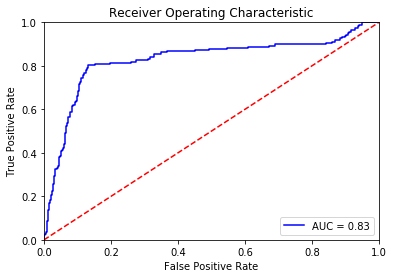

In [65]:
probs = svc_model.predict_proba(test_features)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
roc_auc = metrics.roc_auc_score(y_test, probs)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## f) Qual é o número médio de dígitos por documento para documentos não-spam e documentos spam? 

In [67]:
df = feature_stats(spam_data, DIGITS, spam=1)
print('=> Média do número de dígitos em documentos que são SPAM: {:.2f}'.format(df.loc[DIGITS,'mean']))
df

=> Média do número de dígitos em documentos que são SPAM: 15.76


,count,mean,std,min,25%,50%,75%,max
digits,747.0,15.759036,8.755896,0.0,10.0,16.0,22.0,47.0


In [68]:
df = feature_stats(spam_data, DIGITS, spam=0)
print('=> Média do número de dígitos em documentos que NÃO são SPAM: {:.2f}'.format(df.loc[DIGITS,'mean']))
df

=> Média do número de dígitos em documentos que NÃO são SPAM: 0.30


,count,mean,std,min,25%,50%,75%,max
digits,4825.0,0.299275,1.063086,0.0,0.0,0.0,0.0,23.0


## Utilize o vetorizador Tf-idf nos dados de treinamento, ignorando termos menor que 5 e utilize unigramas, bigramas e trigramas.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w\w\w\w\w+\b", ngram_range=(1,3))
tfidf_matrix =  tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)
print(tfidf_matrix.shape, tfidf_test.shape)

##  Usando essa matriz de termos de documento e duas características adicionais (o comprimento do documento e o número médio de dígitos por documento) treine um modelo de regressão logística, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo.

In [ ]:
train_features = hstack((tfidf_matrix, train_docsize.to_numpy()[:, None], ))
test_features = hstack((tfidf_test, test_docsize.to_numpy()[:, None], ))

In [ ]:
lr_model = LogisticRegression()


In [ ]:
probs = svc_model.predict_proba(test_features)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
roc_auc = metrics.roc_auc_score(y_test, probs)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## g) Qual é o número médio de caracteres que não são palavras (tudo que não é uma letra, dígito ou underscore) por documento para documentos não-spam e documentos spam? Dica: use as classes de caracteres \w e \W do pacote re (regular expressions). 

In [8]:
df = feature_stats(spam_data, NOT_WORDS, spam=1)
print('=> Média de caracteres que não são palavras, por documento, para documentos que são SPAM: {:.2f}'.format(
      df.loc[NOT_WORDS,'mean']))
df

=> Média de caracteres que não são palavras, por documento, para documentos que são SPAM: 29.04


,count,mean,std,min,25%,50%,75%,max
not_words,747.0,29.041499,7.319564,1.0,27.0,30.0,34.0,50.0


In [9]:
df = feature_stats(spam_data, NOT_WORDS, spam=0)
print('=> Média de caracteres que não são palavras, por documento, para documentos que NÃO são SPAM: {:.2f}'.format(
      df.loc[NOT_WORDS,'mean']))
df

=> Média de caracteres que não são palavras, por documento, para documentos que NÃO são SPAM: 17.29


,count,mean,std,min,25%,50%,75%,max
not_words,4825.0,17.291813,14.990677,0.0,8.0,13.0,22.0,253.0


## Utilize o vetorizador CountVectorizer nos dados de treinamento, ignorando termos menor que 5 e utilize unigramas, bigramas e trigramas. 

In [11]:
# O padrão de token utilizado como "default" ignora termos com tamanho menor ou igual a 2 caracteres. 
# Alterei este padrão para ignorar os termos com menos de 5 caracteres.
token_pattern=r"(?u)\b\w\w\w\w\w+\b"
counter = CountVectorizer(stop_words='english', ngram_range=(1, 3), token_pattern=token_pattern)

In [14]:
train_matrix = counter.fit_transform(X_train)
train_matrix.shape

(4179, 22661)

## Usando esta matriz de termos de documento e as seguintes características adicionais: o comprimento do documento, número de dígitos por documento, e o número de caracteres que não são palavras (tudo que não é uma letra, dígito ou underscore), treine um modelo de regressão logística, e em seguida, calcule a AUC usando os dados de teste. Avalie com diferentes valores para o parâmetro de regularização C e descreva brevemente como esse parâmetro se comporta no modelo. 

In [19]:
# Transformação equivalente sobre os dados de teste para conseguirmos usar os mesmos tokens como features
test_matrix = counter.transform(X_test)
test_matrix.shape

(1393, 22661)

In [20]:
train_matrix

<4179x22661 sparse matrix of type '<class 'numpy.int64'>'
	with 37770 stored elements in Compressed Sparse Row format>

In [26]:
train_digits, test_digits = train_test_split(spam_data.digits, random_state=0)
train_not_words, test_not_words = train_test_split(spam_data.not_words, random_state=0)

In [36]:
train_digits.to_numpy().shape

(4179,)

In [43]:
ninja = np.array([7]*4179)[:, None]
ninja.shape

(4179, 1)

In [44]:
from scipy.sparse import hstack

# Vamos adicionar os valores de número de dígitos e número de caracteres que não são palavras à matriz 
# de ocorrência dos tokens (mala de palavras) para uso no modelo de regressão logística
train_features = hstack((train_matrix, train_digits.to_numpy()[:, None], train_not_words.to_numpy()[:, None]))
train_features.shape

(4179, 22663)

In [45]:
# A mesma coisa para os dados de teste
test_features = hstack((test_matrix, test_digits.to_numpy()[:, None], test_not_words.to_numpy()[:, None]))
test_features.shape

(1393, 22663)

In [48]:
lrmodel = LogisticRegression(random_state=0, solver='liblinear', C=1.0)

In [49]:
lrmodel.fit(train_features, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
y_pred = lrmodel.predict(test_features)

In [51]:
# predict probabilities
lr_probs = lrmodel.predict_proba(test_features)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

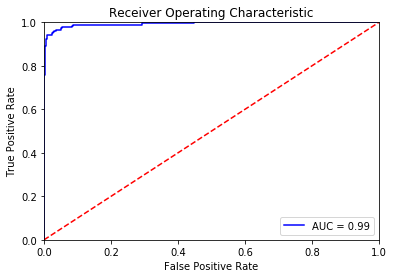

In [58]:
plot_roc_auc(y_test, lr_probs)

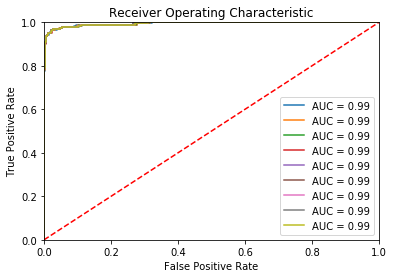

In [64]:
C_parameters = [3 * i for i in range(1, 10)]
models = [LogisticRegression(solver='liblinear', C=c_parameter) for c_parameter in C_parameters]

fpr_array = []
tpr_array  = []
plt.figure(figsize=(12,6))
for model in models:
    model.fit(train_features, y_train)
    probs = model.predict_proba(test_features)[:, 1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, probs)
    fpr_array.append(fpr)
    tpr_array.append(tpr)
    roc_auc = metrics.roc_auc_score(y_test, probs)
    plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Encontre os 10 menores e os 10 maiores coeficientes do modelo e retorne-os juntamente com a pontuação da AUC em uma tupla. A lista dos 10 menores coeficientes deve ser classificada de forma crescente, a lista dos 10 maiores coeficientes de forma decrescente.

--------------------------------------------

### Questão 2

Objetivo: Modelagem de Tópicos

a) Estimar os parâmetros do modelo LDA no corpus e salvar na variável ldamodel. Extrair 10 tópicos usando corpus e id_map, com os parâmetros 'passes' = 25 e 'random_state' = 35.

b) Usando ldamodel, encontre uma lista dos 10 tópicos e das 10 palavras mais significativas em cada tópico. Isso deve ser estruturado como uma lista de 10 tuplas.

c) Baseando-se na seguinte lista de tópicos, relacione com os tópicos encontrados pelo algoritmo gensim no corpus. A lista de tópicos pode ser estendida por vocês.

    Tópicos:
    Saúde, Ciência, Automóveis, Política, Governo, Viagem,
    Computadores e TI, Esportes, Negócios, Sociedade e
    Estilo de vida, Religião, Educação.

In [2]:
import pickle
import gensim
from sklearn.feature_extraction.text import CountVectorizer

with open('./CSV/newsgroups', 'rb') as f:
    newsgroup_data = pickle.load(f)

vect = CountVectorizer(min_df=20, max_df=0.2, stop_words='english', 
                       token_pattern='(?u)\\b\\w\\w\\w+\\b')
X = vect.fit_transform(newsgroup_data)

corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

id_map = dict((v, k) for k, v in vect.vocabulary_.items())